In [1]:
%reload_ext autoreload
%autoreload 2

## Dependencias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.model_selection import train_test_split

sys.path.append("../")
import src.constants as c
from src.eda import print_stats_for_categorical_feature, stats_for_numerical_features
from src.utils import save_to_pickle

pd.set_option('display.max_columns', 100)

## Lectura de datos

In [3]:
df = pd.read_csv(c.original_data)

## Análisis Exploratorio de datos

In [4]:
obs, cols = df.shape
print(f"Número de observaciones: {obs}\nNúmero de columnas: {cols}")

Número de observaciones: 21613
Número de columnas: 21


In [5]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


- Supondremos que estamos interesados en crear un modelo del precio de la vivienda, dadas las demás caracteristicas.
- Las variables `id` y `date` no entran dentro del modelo, solo son informativas.
- Observamos que la variable `date` está mal formateada. Vamos a arreglar esto.

In [6]:
df = df.drop(columns=[c.id]) # eliminamos id
# hipotesis: los primeros 8 numeros corresponden a la fecha en formato yyyymmdd
df[c.date] = df[c.date].str[:8]
df[c.date] = pd.to_datetime(df[c.date], format="%Y%m%d")

Los datos corresponden al siguiente periodo temporal:

In [7]:
min_date, max_date = df[c.date].min(), df[c.date].max()
print((min_date.strftime("%Y-%m-%d"), max_date.strftime("%Y-%m-%d")))

('2014-05-02', '2015-05-27')


Con el fin de estudiar como varia la distribución de los datos con el tiempo, los agrupamos en dias, semanas y meses (usando el proximo domingo y el proximo fin de mes, respectivamente).

In [8]:
df["prox_domingo"] = df[c.date] + pd.offsets.Week(weekday=6)
df["prox_fin_mes"] = df[c.date] + pd.offsets.MonthEnd(0)

En la siguiente gráfica se observa que en alrededor de enero del 2015 hubo una cantidad muy inferior de observaciones.

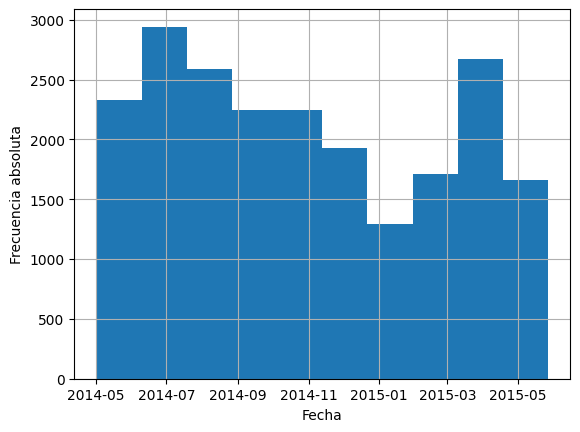

In [9]:
fig, ax = plt.subplots()
df[c.date].hist(ax=ax)
ax.set(xlabel="Fecha", ylabel="Frecuencia absoluta")
plt.show()

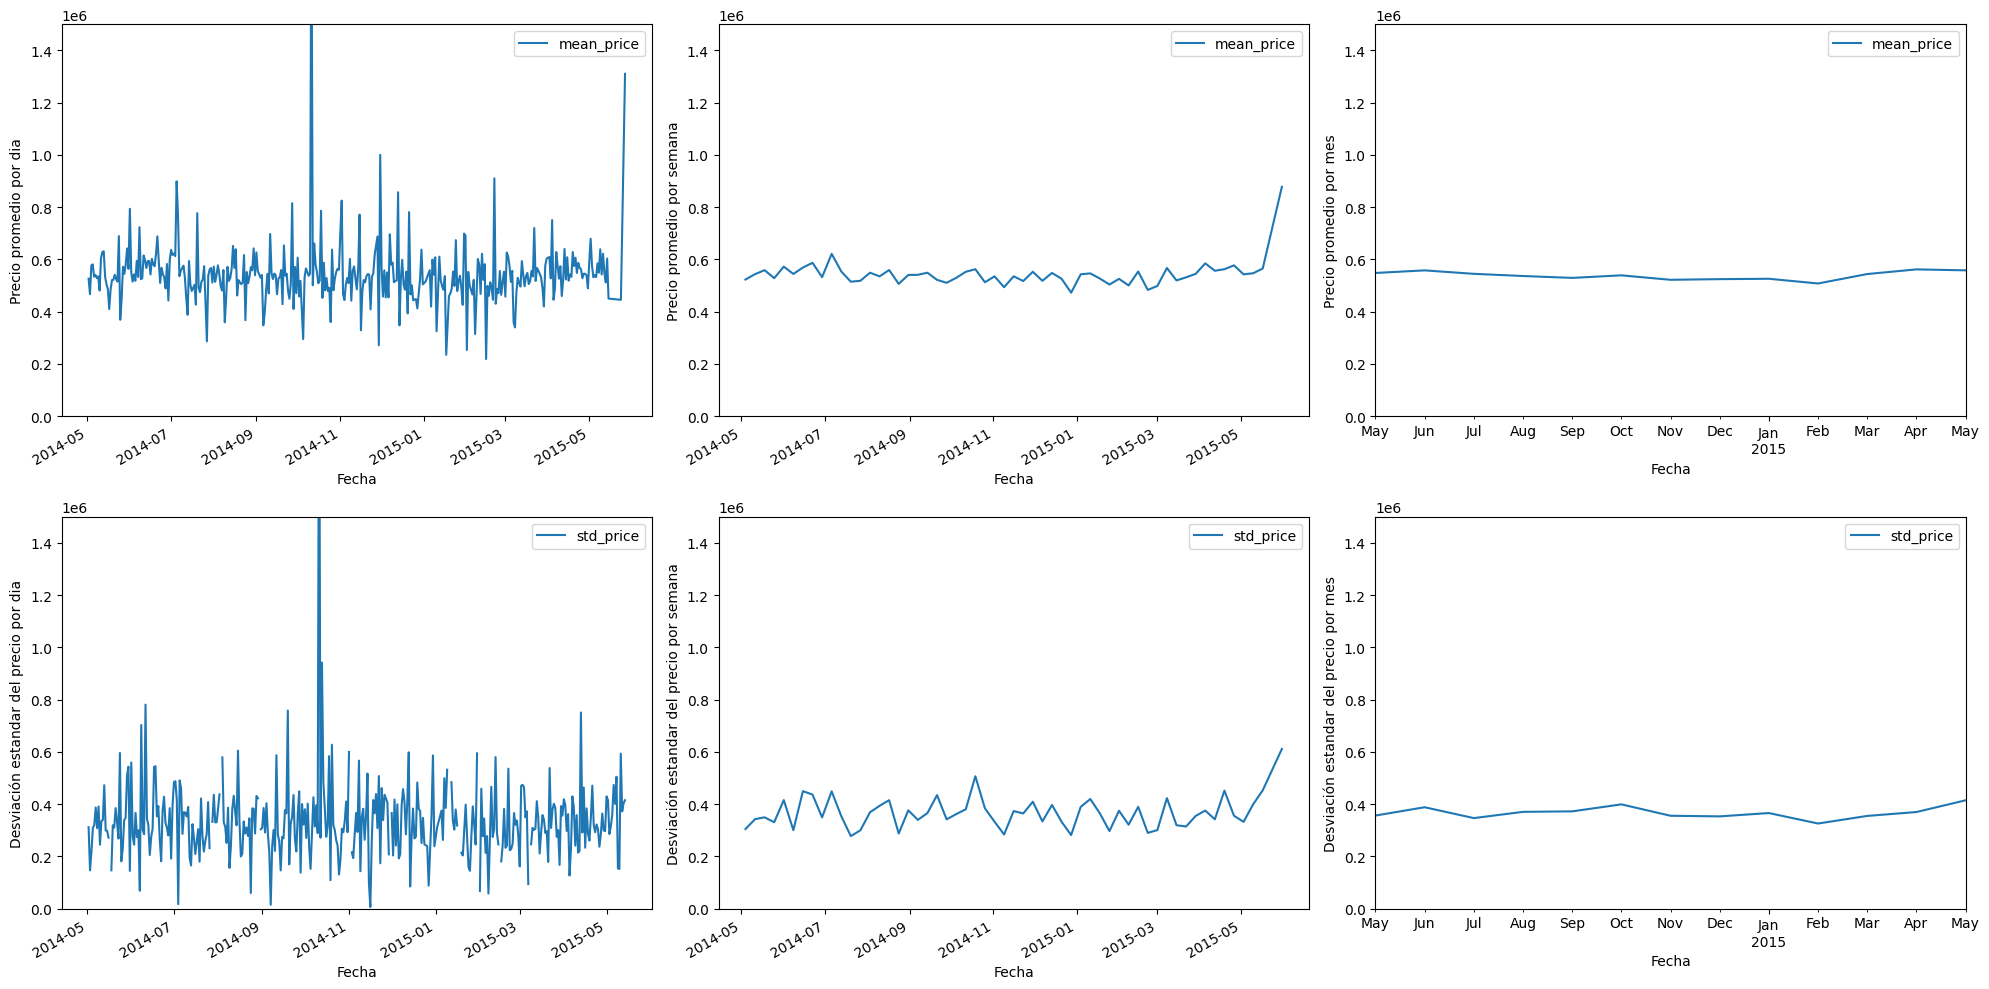

In [10]:
def plot_in_ax(date, stat, ax):
    stats = {f"{stat}_{c.target}": (c.target, stat)}
    df.groupby(date).agg(**stats).plot(ax=ax)

fig, ax = plt.subplots(2, 3, figsize=(20,10))
plot_in_ax(c.date, "mean", ax[0, 0])
plot_in_ax("prox_domingo", "mean", ax[0, 1])
plot_in_ax("prox_fin_mes", "mean", ax[0, 2])

ax[0, 0].set(ylim=[0,1.5e6], ylabel="Precio promedio por dia", xlabel="Fecha")
ax[0, 1].set(ylim=[0,1.5e6], ylabel="Precio promedio por semana", xlabel="Fecha")
ax[0, 2].set(ylim=[0,1.5e6], ylabel="Precio promedio por mes", xlabel="Fecha")

plot_in_ax(c.date, "std", ax[1, 0])
plot_in_ax("prox_domingo", "std", ax[1, 1])
plot_in_ax("prox_fin_mes", "std", ax[1, 2])

ax[1, 0].set(ylim=[0,1.5e6], ylabel="Desviación estandar del precio por dia", xlabel="Fecha")
ax[1, 1].set(ylim=[0,1.5e6], ylabel="Desviación estandar del precio por semana", xlabel="Fecha")
ax[1, 2].set(ylim=[0,1.5e6], ylabel="Desviación estandar del precio por mes", xlabel="Fecha")

plt.tight_layout()
plt.show()

Observamos que la distribución de los precios es estable en el tiempo (salvo por casos atipicos en la ultima semana). Antes de seguir analizando datos, procedemos a hacer un particionado de los datos en train-test. Dado que el target tiene una distribución estable, el particionado puede hacerse con un muestreo aleatorio simple. (Si, por el contrario, la distribución fuera cambiante, estableceriamos el conjunto test en periodo temporal proximo al presente con el fin de que las estimaciones del perfomance del modelo en un conjunto de datos reciente puedan ser tomadas de las evaluaciones en test). 

## Particion en train-test

In [11]:
X = df.drop(columns=[c.target, c.date, "prox_domingo", "prox_fin_mes"])
y = df[c.target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

prop = len(X_train) / len(X)
print(f"Porcentaje de obs en train: {prop * 100 : .2f}%")

Porcentaje de obs en train:  90.00%


## Más análisis exploratorios: Porcentaje de nulos

In [12]:
data_nul = X_train.isna().mean() * 100
df_nul = pd.DataFrame(data_nul, columns=["porcentaje_nulos"])
df_nul

,porcentaje_nulos
bedrooms,0.0
bathrooms,0.0
sqft_living,0.0
sqft_lot,0.0
floors,0.0
waterfront,0.0
view,0.0
condition,0.0
grade,0.0
sqft_above,0.0


## Variables categoricas y numericas

In [13]:
def get_probs(X, col):
    probs = X.groupby(col).size() / len(X)
    return probs

def get_max_prob(X, col):
    probs = get_probs(X, col)
    return np.max(probs), len(probs)

def get_df_probs(X):
    predictors = X.columns.tolist()
    rows = []
    for col in predictors:
        max_prob, nclasses = get_max_prob(X, col)
        rows.append((col, max_prob, nclasses))
    df_probs = pd.DataFrame(rows, columns=["variable", "max_prob", "nclasses"])
    return df_probs

In [14]:
df_probs = get_df_probs(X_train)
df_probs = df_probs.sort_values("max_prob").reset_index(drop=True)

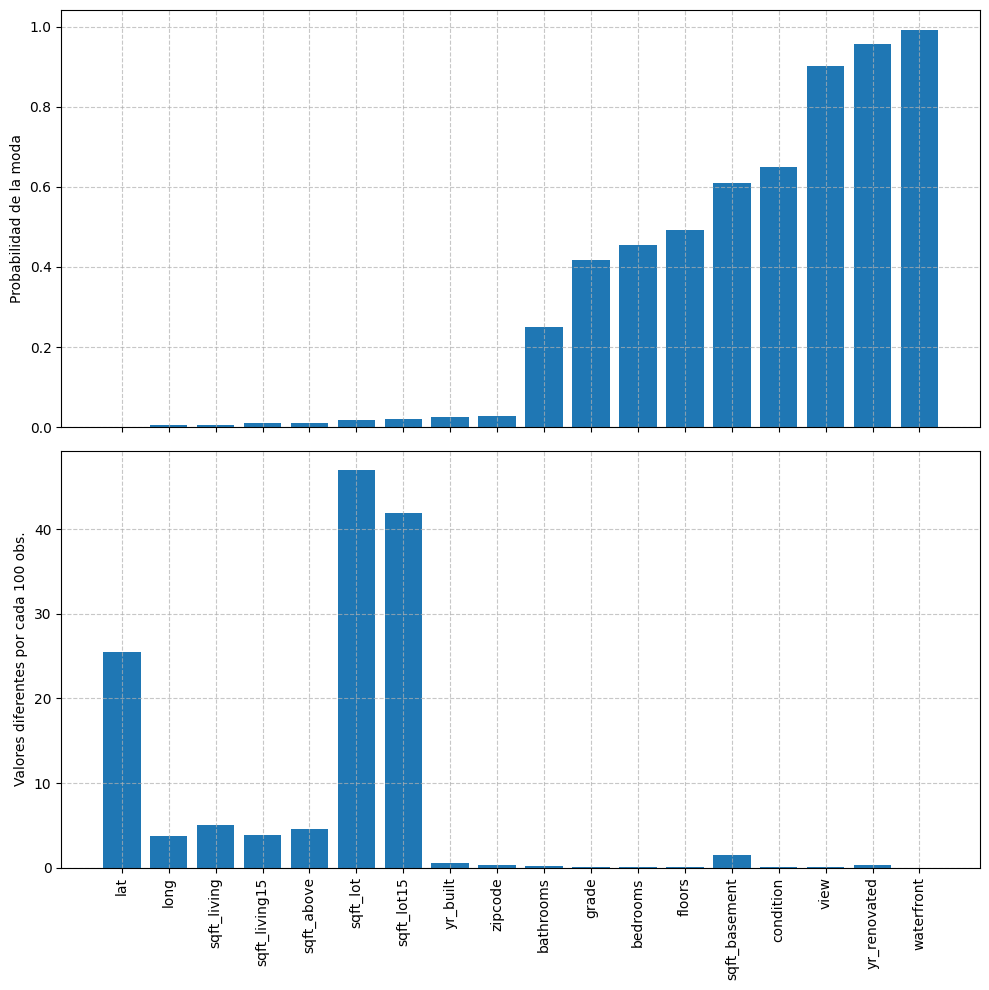

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

x = df_probs["variable"]
y1 = df_probs["max_prob"]
y2 = 100 * df_probs["nclasses"] / len(X_train)

# Gráfica superior
ax[0].bar(x, y1)
ax[0].tick_params('x', labelrotation=90, labelbottom=False)  # Oculta los xlabels pero deja las marcas
ax[0].grid(True, which='both', linestyle='--', alpha=0.7)  # Añade grid
ax[0].set(ylabel="Probabilidad de la moda")

# Gráfica inferior
ax[1].bar(x, y2)
ax[1].tick_params('x', labelrotation=90)
ax[1].grid(True, which='both', linestyle='--', alpha=0.7)  # Añade grid
ax[1].set(ylabel="Valores diferentes por cada 100 obs.")

plt.tight_layout()
plt.show()

In [16]:
numericas = ["lat", "long", "sqft_living", "sqft_living15", "sqft_above", "sqft_lot", "sqft_lot15", "sqft_basement", "yr_built", "bathrooms", "bedrooms", "yr_renovated"]
categoricas = ["zipcode", "grade", "floors", "condition", "view", "waterfront"]

## Filtro de outliers en target y predictores

In [17]:
p = 0.001
q = 0.999

def get_df_out(X, y):
    df_copy = X.copy()
    df_copy[c.target] = y
    columns = df_copy.columns.tolist()
    rows = []

    for col in columns:
        variable = df_copy[col]
        lower, upper = np.quantile(variable, [p, q], method="inverted_cdf")
        out_lower = (variable < lower).mean()
        out_upper = (variable > upper).mean()
        rows.append((col, lower, upper, out_lower, out_upper))

    names = ["variable", "lower", "upper", "out_lower", "out_upper"]
    df_out = pd.DataFrame(rows, columns=names)
    return df_out

In [18]:
df_out = get_df_out(X_train, y_train)
df_out.style.hide()

variable,lower,upper,out_lower,out_upper
bedrooms,1.000000,8.000000,0.000566,0.000566
bathrooms,0.750000,5.500000,0.000617,0.000977
sqft_living,520.000000,7350.000000,0.000925,0.000977
sqft_lot,713.000000,443440.000000,0.000977,0.000977
floors,1.000000,3.000000,0.000000,0.000360
waterfront,0.000000,1.000000,0.000000,0.000000
view,0.000000,4.000000,0.000000,0.000000
condition,1.000000,5.000000,0.000000,0.000000
grade,4.000000,12.000000,0.000206,0.000617
sqft_above,500.000000,6200.000000,0.000925,0.000977


In [19]:
df_out = df_out.set_index("variable")

def get_limits(col, df_out):
    lower = df_out.loc[col]["lower"]
    upper = df_out.loc[col]["upper"]
    return lower, upper

def filter_outliers(X, y, df_out):
    df_copy = X.copy()
    df_copy[c.target] = y
    cummask_out = np.repeat(True, len(X))
    for col in numericas+[c.target]:
        lower, upper = get_limits(col, df_out)
        mask_out = (lower <= df_copy[col]) & (df_copy[col] <= upper)
        cummask_out &= mask_out
    return cummask_out

In [20]:
mask = filter_outliers(X_train, y_train, df_out)
print(f"Porcentaje de outliers en la base train: {(~mask).mean() * 100 : .2f}%")

Porcentaje de outliers en la base train:  1.42%


## Estudio de variables categoricas:

El estudio es quitando outliers.

In [21]:
df_train = X_train.copy()
df_train[c.target] = y_train
mask = filter_outliers(X_train, y_train, df_out)
df_train = df_train[mask]

In [22]:
for feature in categoricas:
    print_stats_for_categorical_feature(df_train, feature)

Summary of zipcode
Number of categories: 70
Most common category: 98103
Highest price: 98039
Lowest price: 98002
Herfindahl–Hirschman index: 0.31%
R2: 43.92%
R2 confidence interval: (42.23%, 46.31%)


,mean_target,count
zipcode,,
98002,2.354157e+05,180
98168,2.449274e+05,240
98032,2.552072e+05,116
98001,2.817833e+05,326
98188,2.839431e+05,122
...,...,...
98109,8.784831e+05,99
98112,1.101469e+06,236
98040,1.161913e+06,242


Summary of grade
Number of categories: 11
Most common category: 7
Highest price: 13
Lowest price: 4
Herfindahl–Hirschman index: 20.96%
R2: 49.39%
R2 confidence interval: (47.39%, 51.43%)


,mean_target,count
grade,,
4,2.290526e+05,19
5,2.601653e+05,189
3,2.620000e+05,1
6,3.030448e+05,1809
7,4.027940e+05,8030
8,5.409931e+05,5396
9,7.723050e+05,2329
10,1.071041e+06,1016
11,1.455300e+06,328


Summary of floors
Number of categories: 6
Most common category: 1.0
Highest price: 2.5
Lowest price: 1.0
Herfindahl–Hirschman index: 27.76%
R2: 9.03%
R2 confidence interval: (7.91%, 10.32%)


,mean_target,count
floors,,
1.0,4.400742e+05,9469
3.5,5.119167e+05,6
1.5,5.604543e+05,1688
3.0,5.745747e+05,554
2.0,6.353804e+05,7315
2.5,1.006531e+06,143


Summary of condition
Number of categories: 5
Most common category: 3
Highest price: 5
Lowest price: 2
Herfindahl–Hirschman index: 37.01%
R2: 0.75%
R2 confidence interval: (0.46%, 1.14%)


,mean_target,count
condition,,
2,331055.746575,146
1,379078.000000,25
4,515876.790808,5048
3,534243.429904,12433
5,605404.594879,1523


Summary of view
Number of categories: 5
Most common category: 0
Highest price: 4
Lowest price: 0
Herfindahl–Hirschman index: 77.42%
R2: 15.86%
R2 confidence interval: (13.69%, 18.16%)


,mean_target,count
view,,
0,4.943420e+05,17326
2,7.819202e+05,848
1,7.971439e+05,300
3,9.286426e+05,434
4,1.333427e+06,267


Summary of waterfront
Number of categories: 2
Most common category: 0
Highest price: 1
Lowest price: 0
Herfindahl–Hirschman index: 97.29%
R2: 5.67%
R2 confidence interval: (3.43%, 8.29%)


,mean_target,count
waterfront,,
0,5.267210e+05,19044
1,1.491310e+06,131


## Estudio de variables numericas

Summary of lat
Mean: 47.56
Median: 47.57
Standard Deviation: 0.14
Range: 0.58
Skewness: -0.48
Kurtosis: -0.70
R2 coefficient: 26.97%
R2 confidence interval: (25.72%, 28.34%)


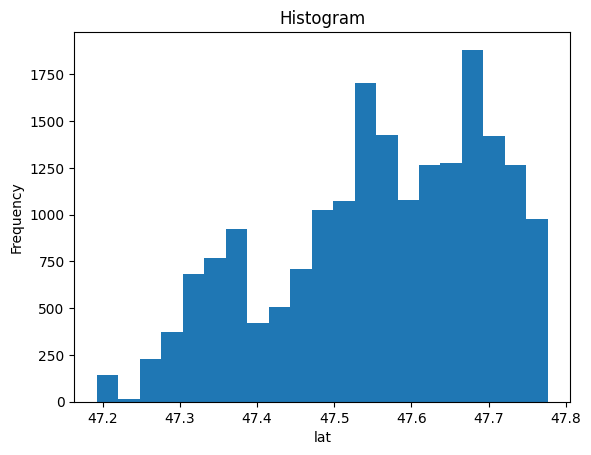

Summary of long
Mean: -122.22
Median: -122.23
Standard Deviation: 0.14
Range: 0.80
Skewness: 0.75
Kurtosis: 0.17
R2 coefficient: 3.09%
R2 confidence interval: (2.52%, 3.88%)


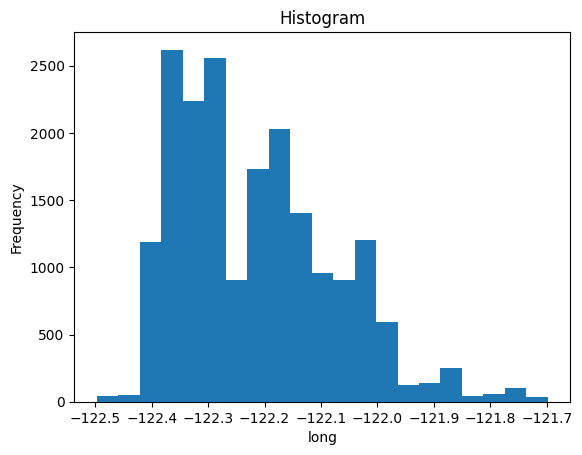

Summary of sqft_living
Mean: 2066.75
Median: 1910.00
Standard Deviation: 872.73
Range: 6460.00
Skewness: 1.06
Kurtosis: 1.57
R2 coefficient: 43.34%
R2 confidence interval: (41.97%, 44.89%)


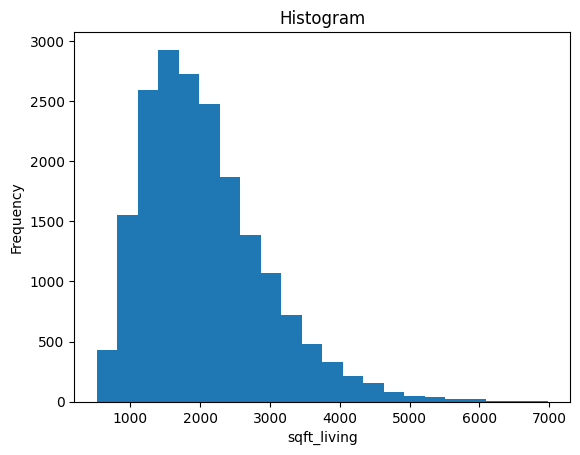

Summary of sqft_living15
Mean: 1982.67
Median: 1840.00
Standard Deviation: 672.01
Range: 4290.00
Skewness: 1.03
Kurtosis: 1.10
R2 coefficient: 33.90%
R2 confidence interval: (32.38%, 35.61%)


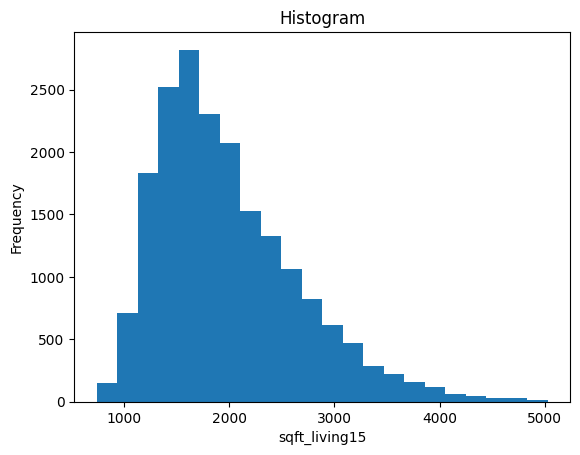

Summary of sqft_above
Mean: 1780.36
Median: 1560.00
Standard Deviation: 799.78
Range: 5590.00
Skewness: 1.22
Kurtosis: 1.57
R2 coefficient: 30.82%
R2 confidence interval: (29.40%, 32.60%)


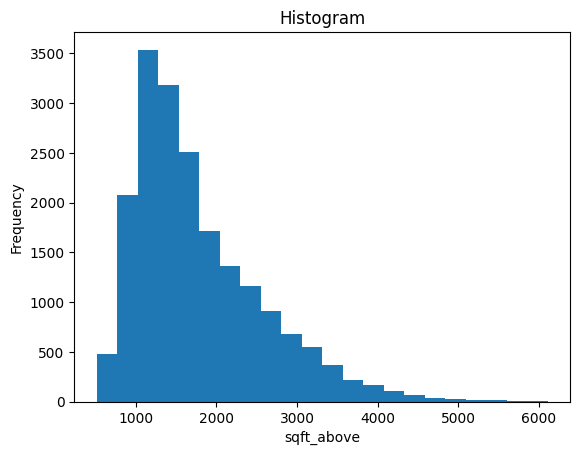

Summary of sqft_lot
Mean: 13786.97
Median: 7590.00
Standard Deviation: 29841.32
Range: 437500.00
Skewness: 7.31
Kurtosis: 65.63
R2 coefficient: 5.03%
R2 confidence interval: (4.23%, 5.94%)


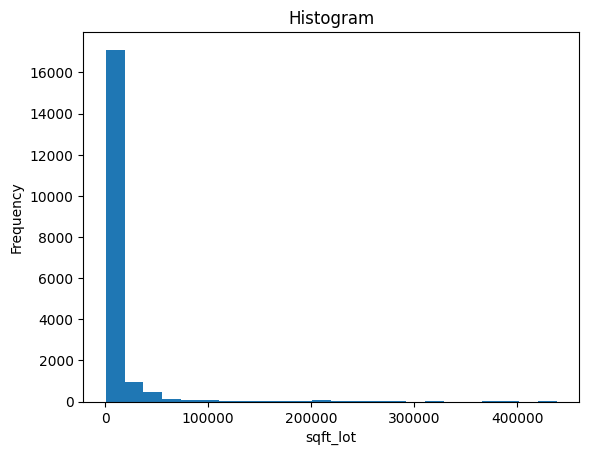

Summary of sqft_lot15
Mean: 12016.51
Median: 7610.00
Standard Deviation: 22426.29
Range: 296628.00
Skewness: 7.00
Kurtosis: 57.72
R2 coefficient: 6.25%
R2 confidence interval: (5.37%, 7.34%)


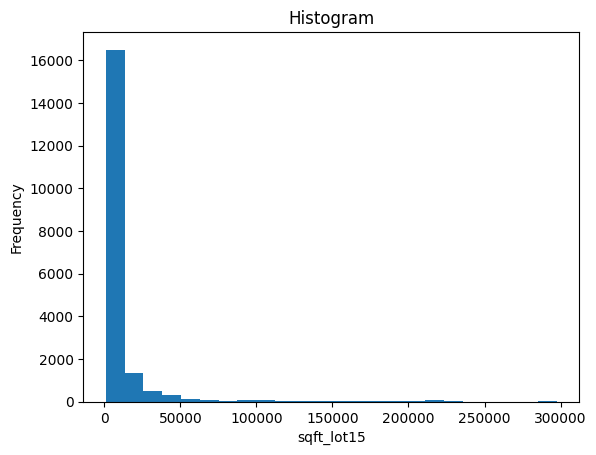

Summary of sqft_basement
Mean: 286.39
Median: 0.00
Standard Deviation: 430.79
Range: 2490.00
Skewness: 1.42
Kurtosis: 1.27
R2 coefficient: 8.58%
R2 confidence interval: (7.36%, 10.00%)


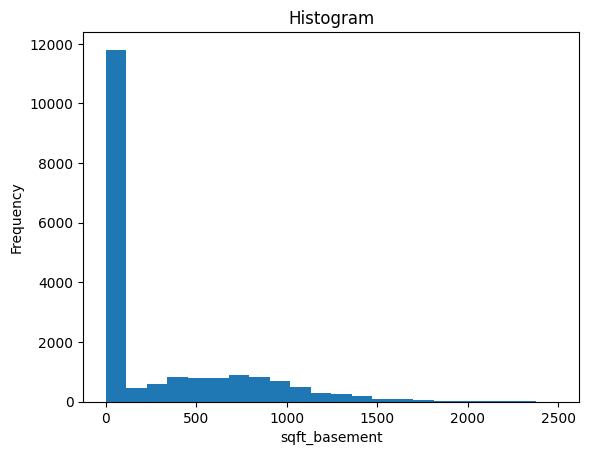

Summary of yr_built
Mean: 1971.03
Median: 1975.00
Standard Deviation: 29.37
Range: 115.00
Skewness: -0.47
Kurtosis: -0.65
R2 coefficient: 2.76%
R2 confidence interval: (2.20%, 3.47%)


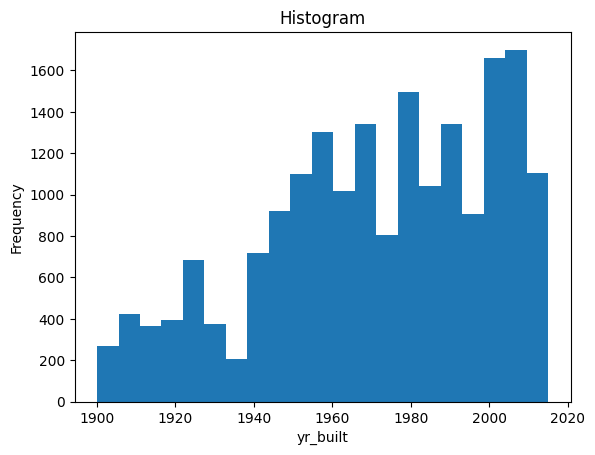

Summary of bathrooms
Mean: 2.11
Median: 2.25
Standard Deviation: 0.75
Range: 4.75
Skewness: 0.33
Kurtosis: 0.25
R2 coefficient: 28.78%
R2 confidence interval: (27.06%, 30.60%)


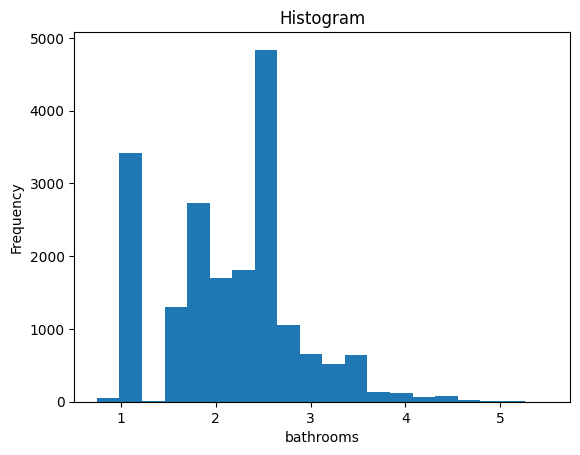

Summary of bedrooms
Mean: 3.37
Median: 3.00
Standard Deviation: 0.88
Range: 7.00
Skewness: 0.43
Kurtosis: 0.87
R2 coefficient: 10.35%
R2 confidence interval: (9.20%, 11.46%)


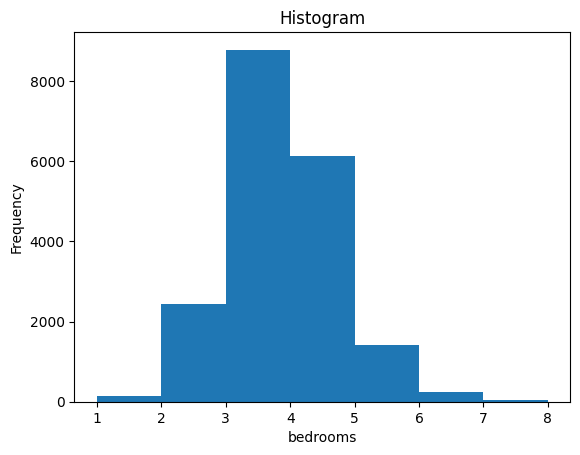

Summary of yr_renovated
Mean: 81.18
Median: 0.00
Standard Deviation: 394.26
Range: 2014.00
Skewness: 4.65
Kurtosis: 19.63
R2 coefficient: 1.54%
R2 confidence interval: (0.96%, 2.29%)


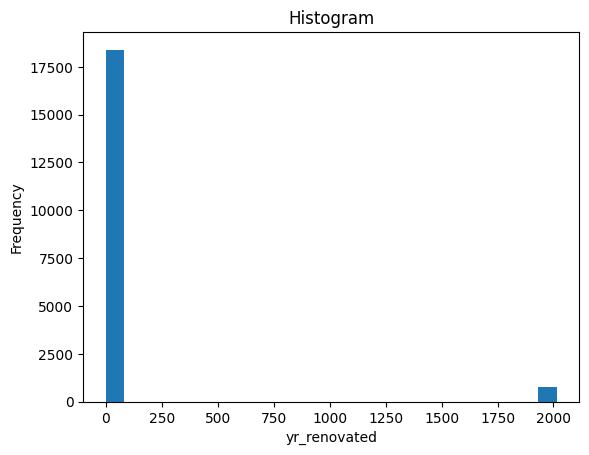

In [23]:
for feature in numericas:
    stats_for_numerical_features(df_train, feature)

## Variables inutiles (en su forma original)

In [24]:
drop = ["condition", "long", "yr_built", "yr_renovated"]

## Guardando información

In [25]:
save_to_pickle([X_train, y_train], c.train_data_v1)
save_to_pickle([X_test, y_test], c.test_data_v1)
save_to_pickle(numericas, c.numericas)
save_to_pickle(categoricas, c.categoricas)
save_to_pickle(drop, c.drop)